In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
ImageDir = '/Users/z001b4m/Udacity_CarND/Term1/Resources/CarND-LaneLines-P1/'

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


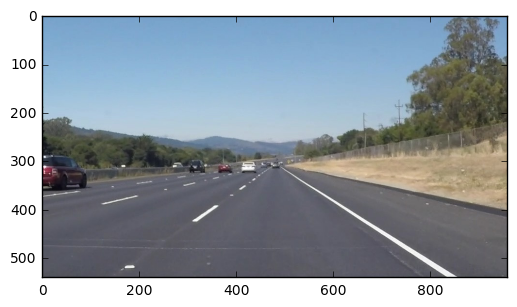

In [3]:
#reading in an image
image = mpimg.imread(ImageDir + 'test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [4]:
image.shape

(540, 960, 3)

## Function Definitions

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def average_lines(lines):
    """
    Given a bunch of lines create average
    lines from the positive and negative 
    slopes.
    """
    slope_pos = []
    slope_neg = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2 - y1)/(x2 - x1)
            if m < 0:
                slope_neg.append(line)
            else:
                slope_pos.append(line)
    line_neg = np.mean(np.array(slope_neg), axis=0)
    line_pos = np.mean(np.array(slope_pos), axis=0)
    
    two_lines = np.vstack((line_neg, line_pos))
    return np.expand_dims(two_lines, axis=1).astype(int)
    
def average_lines_single(lines):
    """
    Given a bunch of lines create an average line
    """
    slope_pos = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2 - y1)/(x2 - x1)
            slope_pos.append(line)
    line_pos = np.mean(np.array(slope_pos), axis=0).astype(int)
    
    return line_pos
    #return np.expand_dims(line_pos, axis=1).astype(int)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def filter_slopes(lines, cutoff):
    """
    Selects lines only within the range of slopes
    """
    
    filt_lines = []
    Slopes = []
    Lengths = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(x2 - x1) < 1.0e-8:
                slope = 1.0e8
            else:
                slope = (y2 - y1)/(x2 - x1)
            length = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
        if ((slope > cutoff['pos']['low']) and (slope < cutoff['pos']['high'])):
            filt_lines.append(line)
            Slopes.append(slope)
            Lengths.append(length)
        if ((slope > cutoff['neg']['low']) and (slope < cutoff['neg']['high'])):
            filt_lines.append(line)
            Slopes.append(slope)
            Lengths.append(length)
       
    return np.array(filt_lines)

def mirror_image(img, line):
    """
    Given a line in an image create a mirrorer
    line w.r.t the the center vertical line
    of the image
    """
    #dy, dx, _ = img.shape
    dy, dx = img.shape
    x_top, y_top, x_bot, y_bot = line
    
    mid_x = dx/2
    x_bot = 2*mid_x - x_bot
    x_top = 2*mid_x - x_top
    
    return np.array([x_top, y_top, x_bot, y_bot], 'int32')
    
def fill_frames_new(image, lines, cutoff=0.6):
    """
    Given a bunch of lines on an image
    select the best two lines with positive
    and negative slopes and fill the frame 
    of the image.
    Selection of the best line can be either
    based on the length of the line or an 
    average of lines.
    There is a fallback option too if neither
    works.
    """
        
    max_len_pos = 0
    max_len_neg = 0
    
    all_neg_lines = []
    all_pos_lines = []
    
    width_x = image.shape[1]
    y_top = image.shape[0]*cutoff
    y_bot = image.shape[0]
    half_x = width_x/2
    
    neg_line = None
    pos_line = None
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (abs(x2 - x1) > 1.0e-8) and (abs(y2 - y1) > 1.0e-8):
                L = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                m = (y2 - y1)/(x2 - x1)
                c = y1 - m*x1
                if m > 0:
                    if L > max_len_pos:
                        max_len_pos = L
                        x_top = int((y_top - c)/m)
                        x_bot = int((y_bot - c)/m)
                        all_pos_lines.append(np.array([x_top, y_top, x_bot, y_bot], 'int32'))
                        if x_top > half_x:
                            pos_line = np.array([x_top, y_top, x_bot, y_bot], 'int32')
                        
                else:
                    if L > max_len_neg:
                        max_len_neg = L
                        x_top = int((y_top - c)/m)
                        x_bot = int((y_bot - c)/m)
                        all_neg_lines.append(np.array([x_top, y_top, x_bot, y_bot], 'int32'))
                        if x_top < half_x:
                            neg_line = np.array([x_top, y_top, x_bot, y_bot], 'int32')
    
    if neg_line is None:
        #neg_line = average_lines_single(np.expand_dims(np.array(all_neg_lines), axis=1))
        neg_line = mirror_image(image, pos_line)
    if pos_line is None:
        #pos_line = average_lines_single(np.expand_dims(np.array(all_pos_lines), axis=1))
        pos_line = mirror_image(image, neg_line)
        
    two_lines = np.vstack((neg_line, pos_line))
    return np.expand_dims(two_lines, axis=1).astype(int)
    
def fill_frames(image, lines):
    new_lines = []
    y_top = image.shape[0]*0.6
    y_bot = image.shape[0]
    pos_bots = []
    neg_bots = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (abs(x2 - x1) > 1.0e-8) and (abs(y2 - y1) > 1.0e-8):
                m = (y2 - y1)/(x2 - x1)
                c = y1 - m*x1
                x_top = int((y_top - c)/m)
                x_bot = int((y_bot - c)/m)
                #print ('***', m>0, x_bot)
                if m>0:
                    pos_bots.append(x_bot)
                else:
                    neg_bots.append(x_bot)
                new_lines.append(np.array([x_top, y_top, x_bot, y_bot], 'int32'))
                #if (m>0 and x_bot>700) or (m<0 and x_bot<300):
                #    new_lines.append(np.array([x_top, y_top, x_bot, y_bot], 'int32'))
    new_lines = np.array(new_lines)
    new_lines = np.expand_dims(new_lines, axis=1)        
    
    return new_lines

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    
    return line_img

def hough_lines_with_image(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    
    return line_img


# Python 3 has support for cool math symbols.

def color_select(image, r, g, b):
    red_threshold = r
    green_threshold = g
    blue_threshold = b

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
            
    return thresholds
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [6]:
import os
os.listdir(ImageDir + "test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [7]:
def process_image(image, params=None):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    if params is None:
        params = {}
        params['blur'] = 15 #15
        params['canny'] = {'low': 20, #20, 
                           'high': 100} #100}
        params['hough'] = {'rho': 1, 
                           'theta': math.pi/180, 
                           'threshold': 20, #3, 
                           'min_line_len': 50, #10, 
                           'max_line_gap': 50} #50}
        params['slope'] = {'pos': {'low': 0.5,
                                   'high': 0.7},
                           'neg': {'low': -0.9,
                                   'high': -0.6}
                           }
        params['frame'] = {'cutoff': 0.6}
        
    v, h, c = image.shape
    vertices = np.array([[h/2, v/2], [0, v], [h, v]], 'int32')
    
    result = grayscale(image)
    result = gaussian_blur(result, params['blur'])
    result = canny(result, params['canny']['low'], params['canny']['high'])
    lines = hough_lines(result, params['hough']['rho'], params['hough']['theta'], 
                         params['hough']['threshold'], params['hough']['min_line_len'],
                         params['hough']['max_line_gap'])
    lines = filter_slopes(lines, params['slope'])
    lines = fill_frames_new(result, lines, params['frame']['cutoff'])
    line_img = np.zeros((*result.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=5)
    
    result = region_of_interest(line_img, [vertices])
    result = weighted_img(result, image)

    return result
    

## Description of Pipeline

The pipeline for lane detection consists of the following steps:
* The input color image is converted into a grayscale image as color is not used as a possible indicator of a lane. 
Moreover, it reduces the processing time.
* A Gaussian blur is applied to the resulting image so that objects with moderately sharp boundaries can be filtered out for the next step. The amount of 'blur' is chosen to be as high as possible while keeping the lane boundaries still detectable in the following step. 
* A Canny transform is applied to the resulting image to detect edges.
* A Hough transform is applied to the resulting image to construct continuous lines out of the line segments returned from the previous step. The goal here is to tune the parameters to capture long lines in the image.
* The previous step creates long lines in the image that don't represent a lane. Most unwanted lines appear at the edges of the pavement with very different slopes compared to the lane lines that always occur at the center of the image. First a regional mask is applied to remove lines from the image where lanes are not expected to appear. Then, a cutoff range in slope values is applied to filter out unwanted lines.
* Finally the surviving lines are superimposed on the original image.

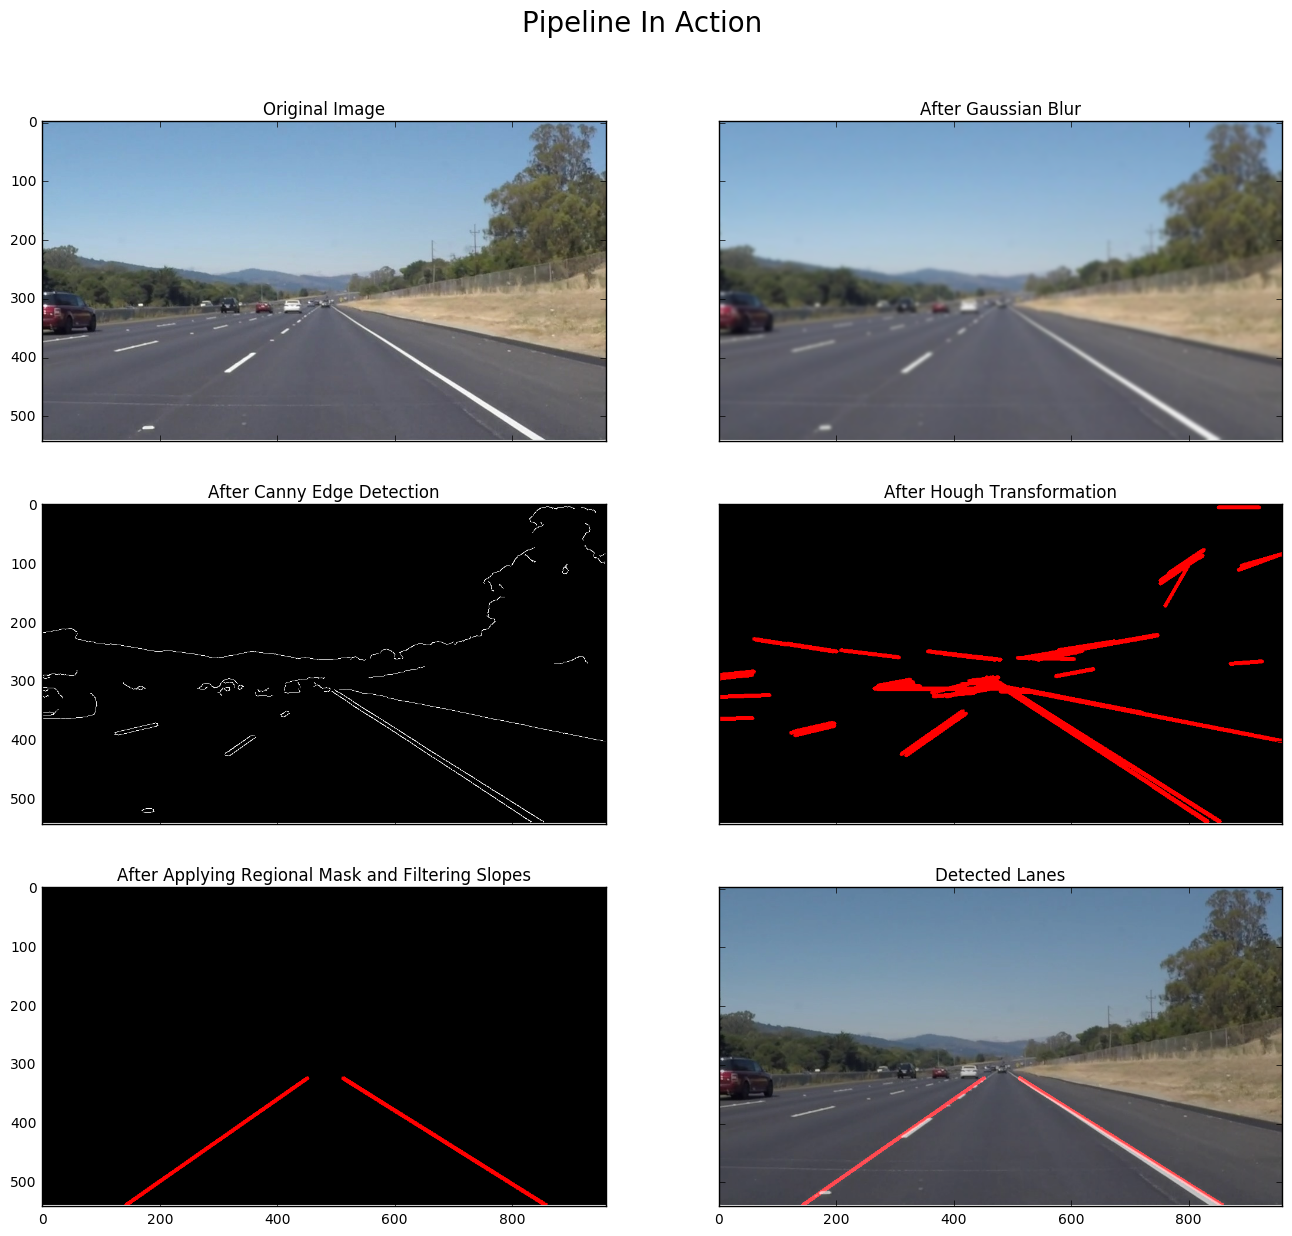

In [8]:
orig_image = mpimg.imread(ImageDir + 'test_images/solidWhiteRight.jpg')
v, h, c = orig_image.shape
vertices = np.array([[h/2, v/2], [0, v], [h, v]], 'int32')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=[16, 14], sharex=True, sharey=True)
ax1.imshow(orig_image)
ax1.set_title("Original Image")

image = gaussian_blur(orig_image, 15)
ax2.set_title("After Gaussian Blur")
ax2.imshow(image)

image = canny(image, 20, 100)
ax3.set_title("After Canny Edge Detection")
ax3.imshow(image, cmap='Greys_r')

lines = hough_lines(image, 1, math.pi/180, 20, 50, 50)
result = np.copy(image)
image = hough_lines_with_image(image, 1, math.pi/180, 20, 50, 50)
ax4.set_title("After Hough Transformation")
ax4.imshow(image)

lines = filter_slopes(lines, {'pos': {'low': 0.5,'high': 0.7}, 'neg': {'low': -0.9, 'high': -0.6}})
lines = fill_frames_new(result, lines, 0.6)
line_img = np.zeros((*result.shape, 3), dtype=np.uint8)
draw_lines(line_img, lines, thickness=5)
ax5.imshow(line_img)
ax5.set_title("After Applying Regional Mask and Filtering Slopes")

result = region_of_interest(line_img, [vertices])
result = weighted_img(result, orig_image)
ax6.imshow(result)
ax6.set_title("Detected Lanes")

plt.suptitle("Pipeline In Action", size=20)

processing  solidWhiteCurve
processing  solidWhiteRight
processing  solidYellowCurve
processing  solidYellowCurve2
processing  solidYellowLeft
processing  whiteCarLaneSwitch


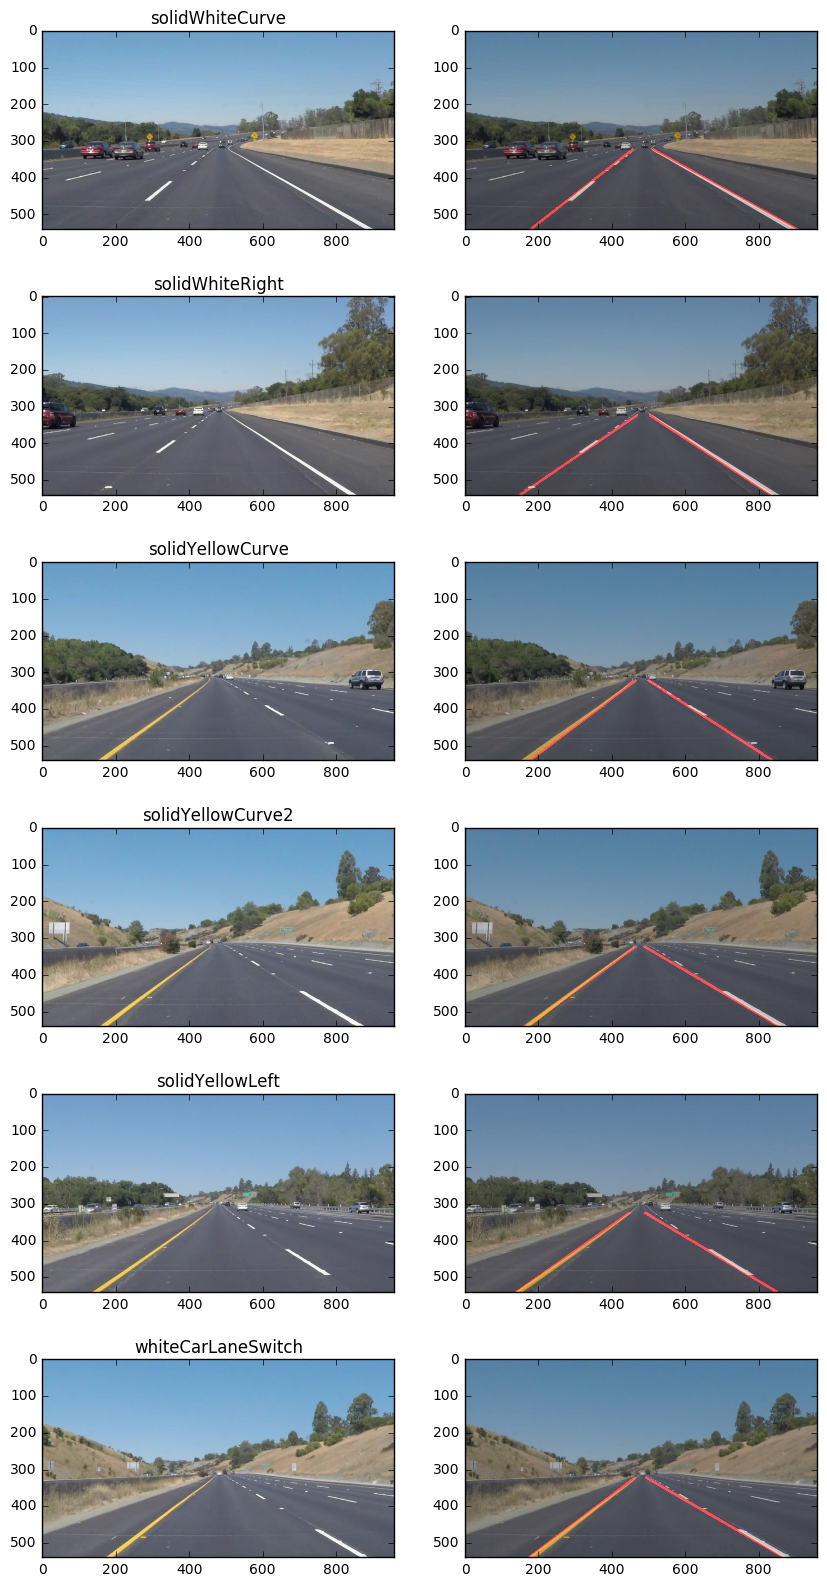

In [9]:
params = {}
#params['area'] = {'vertices': }
params['blur'] = 15
params['canny'] = {'low': 20, 
                   'high': 100}
params['hough'] = {'rho': 1, 
                   'theta': math.pi/180, 
                   'threshold': 3, 
                   'min_line_len': 10, 
                   'max_line_gap': 5}
params['slope'] = {'pos': {'low': 0.5,
                                   'high': 0.7},
                           'neg': {'low': -0.9,
                                   'high': -0.6}
                   }
params['frame'] = {'cutoff': 0.6}

LookDir = ImageDir + "test_images/"
n = len(os.listdir(LookDir))
plt.figure(figsize=[10, 20])
for i, image_file in enumerate(os.listdir(LookDir)):
    print ('processing ', str(image_file.split('.')[0]))
    image = mpimg.imread(LookDir + image_file)
    plt.subplot(n, 2, i*2+1)
    plt.imshow(image)
    plt.title(str(image_file.split('.')[0]))
    plt.subplot(n, 2, i*2+2)
    plt.imshow(process_image(image, params), cmap='gray')
    

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip(ImageDir + "solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 62.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.05 s, sys: 1 s, total: 4.05 s
Wall time: 3.89 s


In [12]:
clip1.fps

25.0

In [13]:
clip1.duration

8.84

In [14]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip(ImageDir + "solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 66.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.95 s, sys: 2.11 s, total: 12.1 s
Wall time: 10.7 s


In [15]:
challenge_output = 'challenge_out.mp4'
clip1 = VideoFileClip(ImageDir + "challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_out.mp4
[MoviePy] Writing video challenge_out.mp4


100%|██████████| 251/251 [00:09<00:00, 26.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_out.mp4 

CPU times: user 8.8 s, sys: 1.69 s, total: 10.5 s
Wall time: 10.8 s


## Potential Shortcomings

There are two major shortcomings of the pipeline:
* There are one or more free parameters at every intermediate step of the pipeline and the only way to test the 
effectiveness of the step is by visual inspection. This method is clearly not scalable.
* The abundance of manually tuned parameters reduces the robustness of the pipeline. Any deviation from expected 
behavior, such as lanes partially blocked by cars or large curvature of lanes, will break the pipeline quickly.

## Possible Improvements

One way to improve lane detection is to average the detected lines over multiple successive frames. 
This is expected to work well for lanes that are reasonably straight, but lanes with shorter radius of curvature will  break this
technique.